In [1]:
path = '/workspace/Weight_compression/Wparam_dataset/hf_model/google--siglip2-base-patch16-224'
path = '/workspace/Weight_compression/Wparam_dataset/hf_model/openai--clip-vit-large-patch14'
from transformers import AutoModel, AutoProcessor 


model = AutoModel.from_pretrained(path)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [3]:
model.text_model

CLIPTextTransformer(
  (embeddings): CLIPTextEmbeddings(
    (token_embedding): Embedding(49408, 768)
    (position_embedding): Embedding(77, 768)
  )
  (encoder): CLIPEncoder(
    (layers): ModuleList(
      (0-11): 12 x CLIPEncoderLayer(
        (self_attn): CLIPSdpaAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): CLIPMLP(
          (activation_fn): QuickGELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (final_layer_norm

In [4]:
import numpy as np
import os
dtype = np.float32

import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import os

from transformers import CLIPVisionModelWithProjection, AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer, OPTForCausalLM, BloomForCausalLM
import numpy

from huggingface_hub import try_to_load_from_cache, _CACHED_NO_EXIST
from huggingface_hub import scan_cache_dir

import glob
import random
import json
import os

device = torch.device("cuda:0")
# device = torch.device("cpu")

def get_named_linears(module):
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def get_blocks(model):
    if model.__class__.__name__ in ("LlamaForCausalLM", "Qwen2ForCausalLM"):
        layers = model.model.layers
    elif model.__class__.__name__ == "LlavaLlamaForCausalLM":
        layers = model.model.layers
    elif isinstance(model, OPTForCausalLM):
        layers = model.model.decoder.layers
    elif isinstance(model, BloomForCausalLM):
        layers = model.transformer.h
    elif "mpt" in str(model.__class__).lower():
        layers = model.transformer.blocks
    elif "falcon" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "bigcode" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "neox" in str(model.__class__).lower():
        layers = model.gpt_neox.layers
    elif model.__class__.__name__ == "LlavaLlamaModel":
        layers = model.llm.model.layers
    elif model.__class__.__name__ in ("CLIPModel"):
        vision_layers = model.vision_model.encoder.layers
        text_layers = model.text_model.encoder.layers
        layers = {'vision': vision_layers,
                  'text': text_layers}
    else:
        raise NotImplementedError(type(model))
    # if not isinstance(layers, dict):
    #     layers = {'': layers}
    return layers

## Dignal Scaled RHT Weight Block

많이 수정함

In [5]:
def flat_to_sym(V, N):
    A = torch.zeros(N, N, dtype=V.dtype, device=V.device)
    idxs = torch.tril_indices(N, N, device=V.device)
    A[idxs.unbind()] = V
    A[idxs[1, :], idxs[0, :]] = V
    return A

def regularize_H(H, n, sigma_reg):
    H.div_(torch.diag(H).mean())
    idx = torch.arange(n)
    H[idx, idx] += sigma_reg
    return H

import sys
sys.path.append('/workspace/Weight_compression/Wparam_dataset')
from utils import *

def RHT_H(H, SU):
    return matmul_hadUt(matmul_hadUt(H * SU).T * SU)

def RHT_W(W, SU, SV):
    return matmul_hadUt(matmul_hadUt(W.T * SV).T * SU)

def incoherence_preprocess(H, W, args):
    # dtype_ = torch.float64 if args.use_fp64 else torch.float32
    dtype_ = torch.float32
    device = H.device
    # device = torch.device('cpu')
    (m, n) = H.shape

    def _dump(Hr, Lhr, msg=''):
        torch.save(Hr, f"{args.save_pfx}/Hr_debug_fft.pt")
        torch.save(Lhr, f"{args.save_pfx}/Lhr_debug_fft.pt")
        raise Exception(msg)

    # diagonally rescale W,H to minimize proxy loss
    scaleWH = None
    Wr = W
    Hr = H
    # if args.rescale_WH:
    if False:
        Hr = H / H.abs().max()
        diagH = torch.diag(Hr)
        diagW2 = torch.diag(W.T @ W)
        diagH = torch.clamp(diagH, min=1e-8)
        diagW2 = torch.clamp(diagW2, min=1e-8)
        scaleWH = (diagH / diagW2).sqrt().sqrt().to(torch.float32)
        scaleWH = scaleWH.clamp(min=1e-8)
        Wr = Wr * scaleWH[None, :]
        Hr = Hr / scaleWH[None, :]
        Hr = Hr / scaleWH[:, None]
        scaleWH = scaleWH.cpu()

    # randomized hadamard transformation on H, W
    if True:
        SU = (torch.randn(n, device=device).sign() + 1e-5).sign().to(dtype_)
        SV = (torch.randn(m, device=device).sign() + 1e-5).sign().to(dtype_)
        Hr = RHT_H(Hr, SU)
        # Wr = RHT_W(Wr, SU, SV)
    # randomized kronecker product on H, W
    elif args.incoh_mode == "kron":
        SU = utils.rand_ortho_butterfly_noblock(n).to(dtype_).to(device)
        SV = utils.rand_ortho_butterfly_noblock(m).to(dtype_).to(device)
        Hr = SU @ Hr @ SU.T
        Wr = SV @ Wr @ SU.T
    else:
        raise NotImplementedError
    SV = SV.cpu()
    SU = SU.cpu()

    # Lhr = torch.linalg.cholesky(Hr)
    Lhr = None
    # if not torch.all(torch.isfinite(Lhr)):
    #     return None

    # Wr = Wr.to(device)

    return Lhr, Hr, Wr, SU, SV, scaleWH

### V2

model_name:  meta-llama--Meta-Llama-3-8B


  0%|          | 0/32 [00:00<?, ?it/s]

Generating heatmap for Layer 10 - self_attn.q_proj...


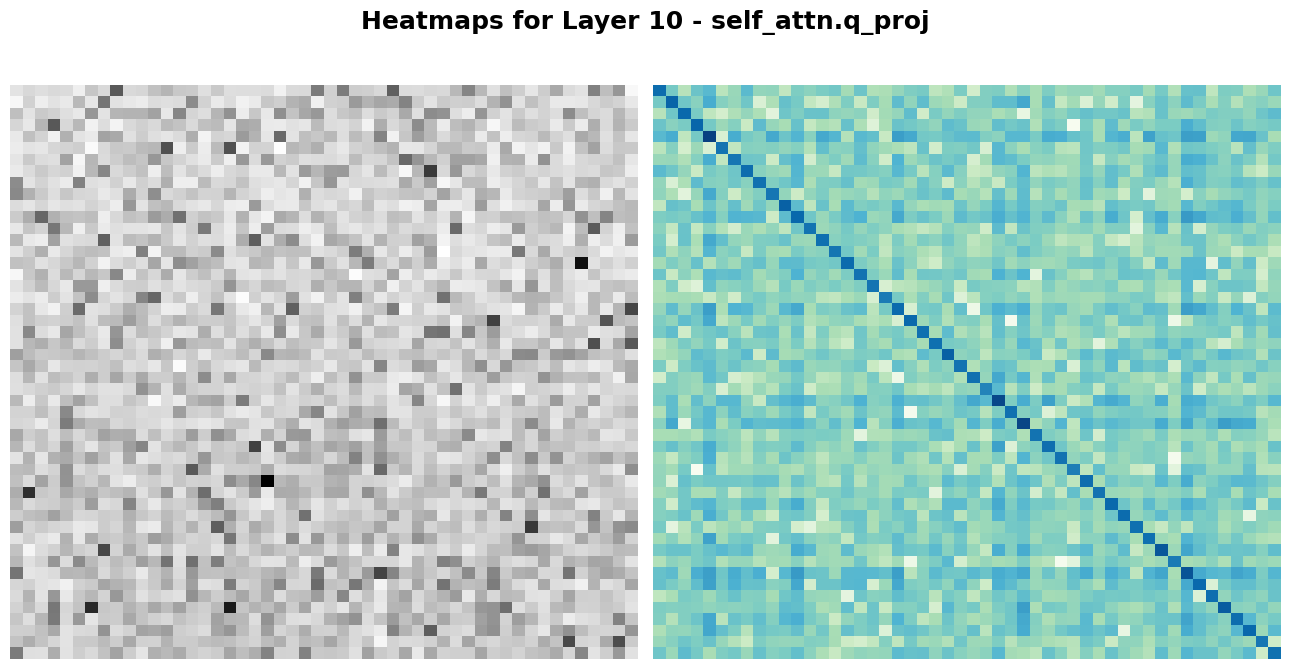

100%|██████████| 32/32 [00:00<00:00, 55.34it/s]


In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm
from transformers import AutoModelForCausalLM


device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_list = ['meta-llama/Meta-Llama-3-8B']
quip_hess_path = ['./quip_hess/llama3_8b_6144']
quip_hess_eig_path = [None]
size_list = [1024]
sigma_reg = 1e-4

# ##################################################################
# # --- 메인 루프 시작 ---
# ##################################################################

for model_name, size, quip_hess, eig_path in zip(model_list, size_list, quip_hess_path, quip_hess_eig_path):

    model_name_fs = model_name.replace('/', '--')
    print('model_name: ', model_name_fs)

    model_path = f"./hf_model/{model_name_fs}"
    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)
    
    raw_data = {'weight': [], 'idx': [], 'layer_type': [], 'scale': []}

    for i in tqdm(range(len(layers))):
        if i not in [10]: continue
        named_linears = get_named_linears(layers[i])

        hess_dict = {
            'qkv': torch.load(f'{quip_hess}/{i}_qkv.pt', map_location=device),
            'o': torch.load(f'{quip_hess}/{i}_o.pt', map_location=device),
            'up': torch.load(f'{quip_hess}/{i}_up.pt', map_location=device),
            'down': torch.load(f'{quip_hess}/{i}_down.pt', map_location=device)
        }

        for n, m in named_linears.items():
            if 'q_proj' in n:
                W = m.weight.data.detach().to(device)
        
                if 'q_proj' in n or 'k_proj' in n or 'v_proj' in n: H_flat = hess_dict['qkv']
                elif 'o_proj' in n: H_flat = hess_dict['o']
                elif 'up_proj' in n or 'gate_proj' in n: H_flat = hess_dict['up']
                elif 'down_proj' in n: H_flat = hess_dict['down']
                else: raise NotImplementedError(n)

                H = flat_to_sym(H_flat['flatH'], H_flat['n']).to(device)
                mu = H_flat['mu'].to(device)
                H.add_(mu[None, :] * mu[:, None])
                n_h = H_flat['n']
                H = regularize_H(H, n_h, sigma_reg)

                
                print(f"Generating heatmap for Layer {i} - {n}...")

                # 데이터를 CPU의 numpy 배열로 변환
                W = W[:50, :50]
                origH = H
                H = H[:50, :50]
                W_abs_np = torch.abs(W).cpu().numpy()
                H_abs_np = torch.abs(H).cpu().numpy()

                # Log 스케일에서 0 값을 처리하기 위해 0이 아닌 최소값을 vmin으로 설정
                vmin_w = W_abs_np[W_abs_np > 0].min() if (W_abs_np > 0).any() else 1e-1
                vmin_h = H_abs_np[H_abs_np > 0].min() if (H_abs_np > 0).any() else 1e-9

                # 플롯 생성 (W와 H를 나란히 표시)
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 7))
                
                # 1. Weight Matrix (W) Heatmap
                im1 = ax1.imshow(W_abs_np, cmap='grey', norm=LogNorm(vmin=vmin_w), aspect='auto')
                ax1.set_title('|W| (Weight Matrix)', fontsize=14)
                ax1.set_xlabel('Input Features')
                ax1.set_ylabel('Output Features')
                # fig.colorbar(im1, ax=ax1, label='Absolute Value (log scale)')

                ax1.set_xticks([])
                ax1.set_yticks([])
                ax1.set_xlabel('')
                ax1.set_ylabel('')
                ax1.set_title('')
                ax1.spines[:].set_visible(False)  # 네 변 테두리 제거

                # 2. Hessian Matrix (H) Heatmap
                im2 = ax2.imshow(H_abs_np, cmap='GnBu', norm=LogNorm(vmin=vmin_h), aspect='auto')
                ax2.set_title('|H| (Hessian Matrix)', fontsize=14)
                ax2.set_xlabel('Flattened Weight Index')
                ax2.set_ylabel('Flattened Weight Index')
                # fig.colorbar(im2, ax=ax2, label='Absolute Value (log scale)')
                
                ax2.set_xticks([])
                ax2.set_yticks([])
                ax2.set_xlabel('')
                ax2.set_ylabel('')
                ax2.set_title('')
                ax2.spines[:].set_visible(False)

                # 전체 제목 및 레이아웃 설정
                plt.suptitle(f'Heatmaps for Layer {i} - {n}', fontsize=18, weight='bold')
                plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # suptitle과 겹치지 않도록 조정
                
                plt.show()

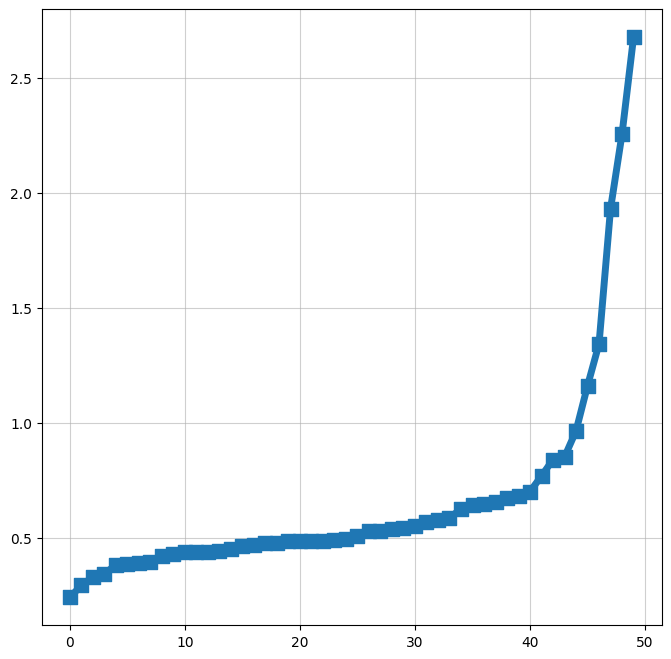

In [41]:
diagonal_elements = H.diag()

# 2. Sort the diagonal elements in ascending order
sorted_diagonal, _ = torch.sort(diagonal_elements)

# 3. Create an index array for the x-axis
indices = np.arange(len(sorted_diagonal))

# 4. Plot the sorted diagonal values
plt.figure(figsize=(8, 8))
plt.plot(indices, sorted_diagonal.cpu().numpy(), lw = 5) # Convert tensor to numpy array for plotting
# plt.scatter(indices, sorted_diagonal.cpu().numpy(), s=90) # s is marker size
plt.scatter(indices, sorted_diagonal.cpu().numpy(), s=90, marker='s', zorder=2)
# plt.axis('square')

# Add labels and title for clarity
# plt.xlabel("Index (Sorted Rank)")
# plt.ylabel("Value of Diagonal Element")
# plt.title("Sorted Diagonal Elements of Matrix H")
plt.grid(True, alpha=0.6)
plt.show()


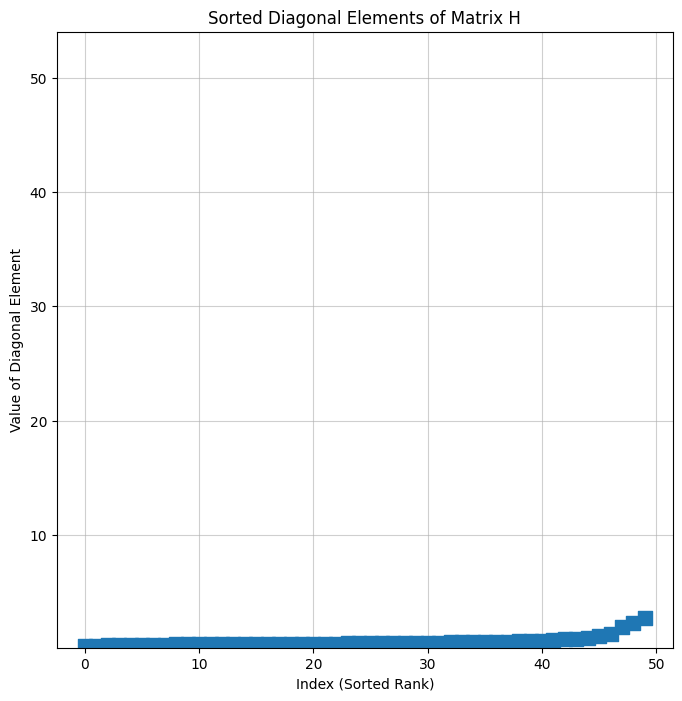

In [36]:
import torch
import matplotlib.pyplot as plt
import numpy as np

diagonal_elements = H.diag()
sorted_diagonal, _ = torch.sort(diagonal_elements)

# 2. Create an index array for the x-axis
indices = np.arange(len(sorted_diagonal))

# 3. Plot the data
plt.figure(figsize=(8, 8)) # You might want to make the figure square-ish too

# Plot the line and scatter
plt.plot(indices, sorted_diagonal.cpu().numpy(), lw=3, zorder=1) # zorder places line behind scatter

# Change marker to 's' for square
plt.scatter(indices, sorted_diagonal.cpu().numpy(), s=90, marker='s', zorder=2)

# --- Add labels and title ---
plt.xlabel("Index (Sorted Rank)")
plt.ylabel("Value of Diagonal Element")
plt.title("Sorted Diagonal Elements of Matrix H")
plt.grid(True, alpha=0.6)

# --- Make the axis square ---
plt.axis('square')

plt.show()